<a href="https://colab.research.google.com/github/Alonso94/GSoC-DGP/blob/master/test_LVM_layers(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from mpl_toolkits.mplot3d import Axes3D
from tensorflow_probability import distributions as tfd
from tensorflow_probability import positive_semidefinite_kernels as tfk

%pylab inline
plt.rcParams['axes.facecolor']='white'
%config InlineBackend.figure_format="png"

Populating the interactive namespace from numpy and matplotlib


In [0]:
#sess=tf.InteractiveSession()
dtype=np.float64

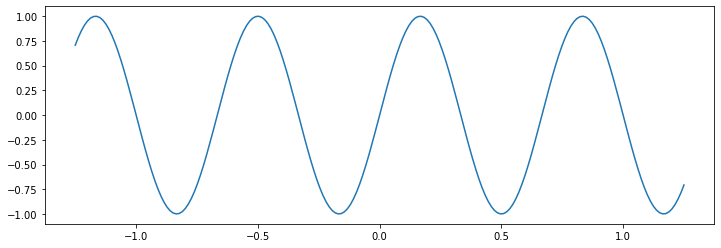

In [0]:
# test matplot
plt.figure(figsize=(12,4))
x=np.linspace(-1.25,1.25,200)
y= np.sin(3*np.pi*x)
plt.plot(x,y)
plt.show()

In [0]:
layer_count=0
DGP_count=0
class Layer:
    prior=None
    # input size for the next layers will be equal to the latent variable size of the previous layer
    def __init__(self, sess, input_size, output_size, DGP_output_size, input_layer=False, limit=1.25,
               a_initial_val=1, ls_initial_val=1, obs_nv_initial_val=1, 
               learning_rate=0.1):
        global layer_count
        layer_count+=1;
        global DGP_count
        with tf.variable_scope("DGP_{}_layer_{}".format(DGP_count,layer_count)):
            # generate training variable of the layer
            # a - amplitude
            # ls - length scale
            # obs_nv - observation noise variance
            # these variables will be optimized during the training

            # finfo : Machine limits for floating point types
            # tiny : The smallest positive usable numbe
            # softplus: a smooth approximation of a rectifier 
            # rectifier(x) = max(0,x)
            # softplus(x) = log(1+exp(x))
            tiny=np.finfo(np.float64).tiny

            a_variable=tf.Variable(initial_value=a_initial_val,name="amplitude",dtype=np.float64)
            self.a=(tiny + tf.nn.softplus(a_variable))

            ls_variable=tf.Variable(initial_value=ls_initial_val,name="length_scale",dtype=np.float64)
            self.ls=(tiny + tf.nn.softplus(ls_variable))

            obs_nv_variable=tf.Variable(initial_value=obs_nv_initial_val,name="observation_noise_variance",dtype=np.float64)
            self.obs_nv=(tiny + tf.nn.softplus(obs_nv_variable))

            # use Exponentiated quadratic kernel
            # or could be called squared exponential, Gaussian, or radial basis function
            # k(x, y) = amplitude**2 * exp(-||x - y||**2 / (2 * length_scale**2))
            self.kernel = tfk.ExponentiatedQuadratic( self.a, self.ls )
            
            init=np.random.random(size=(output_size,1))
            self.latent_index_points=tf.Variable(init, name="latnent_inducing_points")
            
            # define the number of the inducing points
            self.num_inducing_points=200

            # we have to make trainable inducing points
            init_inducing=np.linspace(-limit,limit,self.num_inducing_points,dtype=np.float64)[...,newaxis]
            self.inducing_ind_pts=tf.Variable(init_inducing,dtype=np.float64,name='inducing_index_points')

            init_loc=np.zeros([self.num_inducing_points],dtype=np.float64)
            self.variational_ind_obs_loc=tf.Variable(init_loc,name="variational_inducing_observations_loc")

            init_scale=np.eye(self.num_inducing_points,dtype=np.float64)
            self.variational_ind_obs_scale=tf.Variable(init_scale,name="variational_inducing_observations_scale")

            self.input_placeholder = tf.placeholder(dtype, [None,input_size], name='layer_input')
            self.output_placeholder = tf.placeholder(dtype, [None,DGP_output_size], name='layer_output')
            
            
            
            # construct the VGP distribution
            self.variational_posterior=tfd.VariationalGaussianProcess(kernel=self.kernel, 
                                                                    index_points=self.latent_index_points,
                                                                    inducing_index_points=self.inducing_ind_pts,
                                                                    variational_inducing_observations_loc=self.variational_ind_obs_loc,
                                                                    variational_inducing_observations_scale=self.variational_ind_obs_scale)

            #self.prior=self.variational_posterior
            
            # compute the lower bound terms
            # Compute the logprob from the posterior evaluated at latent_sample
            ################################################
            ##
            ##   (Equation 17 - Doubly stochastic DGP paper)
            ##
            ################################################
            #self.variational_posterior=sess.run(self.variational_posterior,feed_dict={self.input_placeholder: X})

            all_log_probs = self.variational_posterior.log_prob(self.output_placeholder)

            # Reduce sum over the data dimensions
            likelihood_term = tf.reduce_sum(all_log_probs, axis=0)

            # Reduce mean over the batch dimensions
            likelihood_term = tf.reduce_mean(likelihood_term)
            
            if self.prior is None:
                self.prior= self.variational_posterior
                
            # Compute the KL divergence term
            kl_term = self.variational_posterior.kl_divergence(self.prior)

            # Reduce over the dimension.
            kl_term = tf.reduce_mean(kl_term)

            self.loss = likelihood_term - kl_term
            
            self.loss_placeholder = tf.placeholder(dtype, () ,name='loss_input')

            self.DGP_accumulated_loss = self.loss_placeholder + self.loss

            optimizer = tf.train.AdamOptimizer()
            self.train_op = optimizer.minimize(self.DGP_accumulated_loss)
            
            self.sample= self.variational_posterior.sample()
            
            sess.run(tf.initialize_all_variables())  
  
    def update_prior(self,sess):
        self.prior= self.variational_posterior

    def __call__(self, sess, feed_dict):
        #self.variational_posterior=sess.run(self.variational_posterior,feed_dict={self.input_placeholder: X})
        self.sample= self.variational_posterior.sample()
        return sess.run(self.sample,feed_dict)


In [0]:
class DGP:
    def __init__(self, X, Y, num_hidden_layers=2, latent_size=20):
        global DGP_count
        DGP_count+=1

        global layer_cont
        layer_count=0

        input_size=X.shape[1]
        output_size=Y.shape[1]

        self.input_size=input_size
        self.output_size=output_size
        self.num_hidden_layers=num_hidden_layers
        self.latent_size=latent_size

        self.X=X
        self.Y=Y

        self.layers=[]
        
        self.sess=tf.Session()

        self.build_model(self.sess)
        
        self.input_placeholder=tf.placeholder(dtype,[None,1],name="DGP_input")
        self.output_placeholder=tf.placeholder(dtype,[None,1],name="DGP_output")
        
        self.loss=0
    
    def build_model(self,sess):
    
        self.layers.append(Layer(sess,self.input_size,self.latent_size,self.output_size))
        for i in range(self.num_hidden_layers):
            self.layers.append(Layer(sess,self.latent_size,self.latent_size,self.output_size))
        self.layers.append(Layer(sess,self.latent_size,self.output_size,self.output_size))
    
    def optimize(self, X , Y):
        x= self.X
        for i in range(len(self.layers)):
            print(i)
            feed_dict={self.layers[i].input_placeholder:x,
                       self.layers[i].output_placeholder:Y,
                       self.layers[i].loss_placeholder:self.loss}
            self.loss=self.sess.run(self.layers[i].DGP_accumulated_loss,feed_dict)
            self.sess.run(self.layers[i].train_op,feed_dict)
            self.layers[i].update_prior(self.sess)
            x=self.sess.run(self.layers[i].sample,feed_dict)
            print(x.shape)
            x=x.reshape((1,-1))

   
    def predict(self,X):
        Y=[]
        for x in X:
            f_i=x
            print(f_i)
            for i in range(len(self.layers)):
                ################################################
                ##
                ##   (Equation 15 - Doubly stochastic DGP paper)
                ##
                ####### #########################################
                f_i=f_i.reshape((-1,1))
                posterior=self.layers[i].variational_posterior
                # Draw a sample from the variational posterior
                latent_sample = posterior.sample()
                
                lat=self.sess.run(latent_sample,feed_dict={self.layers[i].input_placeholder:f_i})
                print(lat.shape)
                
                mean,var=tf.nn.moments(latent_sample,axes=[0])
                covariance=tfp.stats.covariance(latent_sample, latent_sample, sample_axis=0, event_axis=0)

                m,v,cov=self.sess.run([mean,var,covariance],feed_dict={self.layers[i].input_placeholder:f_i})

                first_term=m

                k=np.eye(i,dtype=np.float64)
                e=np.random.normal(0,k)
                # TODO check sampe's variance in variational GP class
                second_term= np.dot(e,np.sqrt(cov))


                layer_pred=first_term + second_term
                #print(e,np.sqrt(v))
                f_i=layer_pred
            Y.append(f_i)
        return Y


In [0]:
tf.reset_default_graph()
print(x.shape)
x=x.reshape((200,1))
y=y.reshape((200,1))
dgp=DGP(x,y)

(200, 1)


In [0]:
dgp.optimize(x,y)

0
(20,)
1
(20,)
2
(20,)
3
(1,)


In [0]:
dgp.predict(x)

[-1.25]
(20,)


ValueError: sample_axis ([0]) and event_axis ([0]) overlapped